---
# Transit Model with GP from GROND in r
---

In [1]:
#IPython notebook
#Author: Riacardo Ramirez Reyes
%matplotlib inline

In [2]:
import pyfits as py
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

/home/reddtea/.local/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [3]:
import george
from george import kernels
import emcee
import corner

# Function

In [4]:
import batman


def init_batman(time):
    p = batman.TransitParams()
    n = {'t0': 0., 'per': 1., 'rp': 0.1, 'a': 15.,
         'inc': 87., 'ecc':0., 'w':90.}
    for x in n:
        setattr(p, x, n[x])
        
    p.limb_dark = 'quadratic'
    p.u = [0.1, 0.3]
    m = batman.TransitModel(p, time)    
    return p, m

def transit_lightCurve(time, t0, radius, dist, P, inc):
    p = batman.TransitParams()
    p.t0 = t0                       #time of inferior conjunction
    p.per = P                       #orbital period in days
    p.rp = radius                   #planet radius (in units of stellar radii)
    p.a = dist                      #semi-major axis (in units of stellar radii)
    p.inc = inc                     #orbital inclination (in degrees)
    p.ecc = 0.                      #eccentricity
    p.w = 0.                        #longitude of periastron (in degrees)
    p.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
    p.limb_dark = "quadratic"       #limb darkening model
    
    m = batman.TransitModel(p, time)    #initializes model
    flux = m.light_curve(p)          #calculates light curve
    
    return (flux)



Neptune_Density = 1638 #kg/m3.
Jupiter_Density = 1326 #kg/m3.
Earth_Density = 5520 #kg/m3.
Earth_radius = 6371000 #m
Jupiter_Radius = 69911000 #m
Jupiter_Mass = 1.898e+27 #kg
Sun_radius = 695700000 #m
au = 149597870700 #m

def RadiusPlanet(density, Mass, StellarRadius): # in jupiter mass and solar radius
    SR = StellarRadius*Sun_radius
    M = Mass*Jupiter_Mass
    r = (3*(M/density) /(4*np.pi))**(1/3)
    return r/SR  # radius in star ratio

def distancePlanet(distance, StellarRadius): # in au, and solar radius
    d = distance*au
    SR = StellarRadius*Sun_radius
    return d/SR  # distance in star ratio

In [5]:
def gaussian(x, sigma):
    coef = -(x*x)/(2*sigma*sigma)
    return 1/np.sqrt(2*np.pi*sigma*sigma) * np.exp(coef)

# Read Data

In [6]:
path =  ''#"/Volumes/SEAGATE1/Reduction/GROND/"

In [7]:
x, y, x_error, y_error = np.load(path + 'transit_ground_r.npy')

# initialize batman
P, M = init_batman(x)

<ErrorbarContainer object of 3 artists>

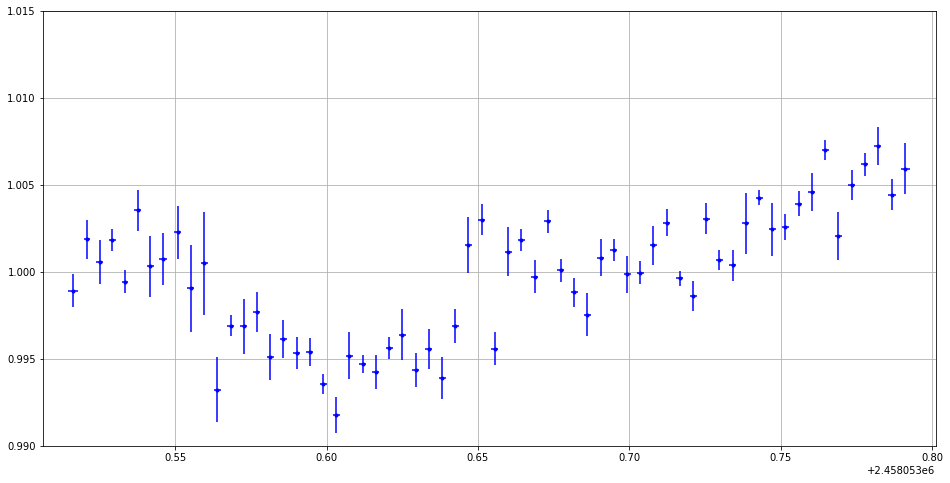

In [8]:
x.shape

madness = 40
xa = np.sort(np.random.uniform(min(x), max(x), madness))
yarr = np.random.normal(np.mean(y_error), np.std(y_error), madness)
#print(y_error)

ya = transit_lightCurve(xa, 2456915.6997, 0.0704, 101.1576001138329, 24.73712, 89.912)
ya *= np.random.uniform(0.998, 1.003, madness)

plt.subplots(figsize=(16,8))
plt.grid(True)
plt.xlim( (min(xa)-0.01) , (max(xa+0.01)))
plt.ylim(0.99, 1.015)

#plt.errorbar(x, y, xerr=x_error, yerr=y_error, fmt='b.', alpha=1/1.)
plt.errorbar(xa, ya, xerr=xarr, yerr=yarr, fmt='r.', alpha=1/1.)
#print(ya)

# Plot Data

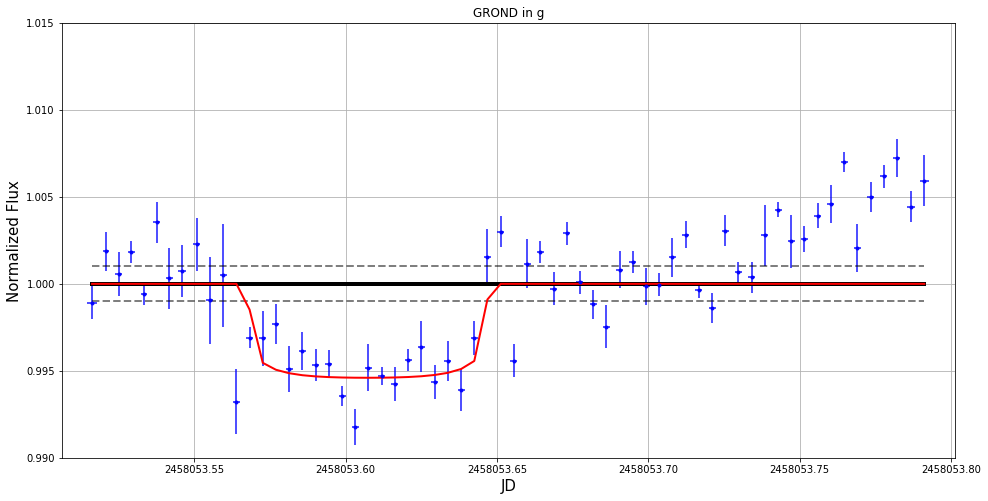

In [9]:
xx = np.append(x, xa)
xx_error = np.append(x_error, xarr)
yy = np.append(y, ya)
yy_error = np.append(y_error, yarr)

orden = np.argsort(xx)

xx, yy, xx_error, yy_error = xx[orden], yy[orden], xx_error[orden], yy_error[orden]


#print(yy_transit)
plt.subplots(figsize=(16,8))
plt.grid(True)
plt.xlim( (min(xx)-0.01) , (max(xx+0.01)))
plt.ylim(0.99, 1.015)

plt.plot((xx[0], xx[-1]), (1.0 - 0.1/100, 1.0 - 0.1/100), 'k--', linewidth=2, alpha = 0.5)
plt.plot((xx[0], xx[-1]), (1.0 + 0.1/100 , 1. + 0.1/100), 'k--', linewidth=2, alpha = 0.5)
plt.plot((xx[0], xx[-1]), (1., 1.), 'k', linewidth=4)

#print(xx)
plt.errorbar(xx, yy, xerr=xx_error, yerr=yy_error, fmt='b.', alpha=1/1.1)

                             #time, t0,     radius,        dist,            P,        inc
y_transit = transit_lightCurve(x, 2456915.6997, 0.0704, 101.1576001138329, 24.73712, 89.912)

yy_transit = transit_lightCurve(x, 2456915.6997, 0.0704, 101.1576001138329, 24.73712, 89.912)
#print(yy_transit)
plt.plot(xx, yy_transit, 'r',  linewidth=2)

plt.ylabel('Normalized Flux', fontsize=15)
plt.xlabel('JD', fontsize=15)
plt.title('GROND in g')
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

# Gaussian Process

In [10]:
def give_initial(nwalkers):
    ndim = 4
    T0 = 2456915.70
    r = 0.0704
    k_a = 1.0e-3 # amplitud kernel
    k_r = 3 # radial kernel

    param = []
    for i in range(nwalkers):  
        t1 = T0  + 1e-3*np.random.randn() # Normal distribution 1-1 4-4
        t2 = r   + 1e-4*np.random.randn()
        t6 = k_a + 1*1e-4*np.random.randn()
        t7 = k_r + 1*1e-0*np.random.randn()
        param.append((t1,t2,np.abs(t6),np.abs(t7)))
    return param, ndim

def give_initial_pt(nwalkers):
    ndim = 4
    ntemp = 2
    T0 = 2456915.70
    r = 0.0704
    k_a = 1.0e-3 # amplitud kernel
    k_r = 3 # radial kernel

    param = []
    for i in range(nwalkers):  
        t1 = T0  + 1e-3*np.random.randn() # Normal distribution 1-1 4-4
        t2 = r   + 1e-4*np.random.randn()
        t6 = k_a + 1*1e-4*np.random.randn()
        t7 = k_r + 1*1e-0*np.random.randn()
        param.append((t1,t2,np.abs(t6),np.abs(t7)))
    param = np.array([param for _ in range(ntemp)])
    return param, ndim

In [11]:
#give random variables
def plus_random_initial(param, nwalkers):
    T0, r, k_a, k_r = param
    t = []
    for i in range(nwalkers):  
        t1 = T0  + 1e-4*np.random.randn() # Normal distribution 1-1 4-4
        t2 = r   + 1e-5*np.random.randn()
        t6 = k_a + 1*1e-4*np.random.randn()
        t7 = k_r + 1*1e-0*np.random.randn()
        t.append((t1,t2, np.abs(t6),np.abs(t7)))
    return t

In [12]:
data = (xx, yy, yy_error)

In [13]:
nwalkers = 50
p0, ndim = give_initial_pt(nwalkers)

In [14]:
def lnprob_gp(param, x, y, yerr):
    lp = lnprior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_gp(param, x, y, yerr)

def lnprior(param):
    T0, r, k_a, k_r = param
    if not (2456915.67 < T0  < 2456915.73 and 0.05 < r  < 0.09 and
        0 < k_a < 5.0e-2 and 0 < k_r < 6.):
        return -np.inf
    
    mu = 0.07 # mean of the Normal prior
    sigma = 0.004 # standard deviation of the Normal prior
    prob_r = np.log(gaussian(r - mu, sigma))
    
    mu = 2456915.70
    sigma =  0.005
    prob_t0 = np.log(gaussian(T0 - mu, sigma))
    prob = prob_t0
    return prob
    
    #return -np.inf

def lnlike_gp(param, x, y, yerr):
    radius = 10.**param[-1]
    gp = george.GP(param[-2] * kernels.Matern32Kernel(radius))
    gp.compute(x, yerr)
    return gp.lnlikelihood(y - Model(param[:-2], x))

def Model(param, x):
    T0, r = param
    transit = transit_lightCurve(x, T0, r, 101.1576001138329, 24.73712, 89.912)
    t = x - x[0]
    return transit


#def Model2(param, x):
#    T0, r, p = param
#    transit = transit_lightCurve(x, T0, r, 101.1576001138329, p, 89.912)
#    t = x - x[0]
#    return transit

In [15]:
#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gp, args=(data))
sampler = emcee.PTSampler(2, nwalkers, ndim, lnlike_gp, lnprior, loglargs=[xx, yy, yy_error])

In [16]:
#len(0.02 * kernels.Matern32Kernel(radius))

In [17]:
print("Running burn-in")
print(p0.shape)
#%time p0, lnp, _ = sampler.run_mcmc(p0, 200)

for p, lnprob, lnlike in sampler.sample(p0, iterations=200):
    pass

Running burn-in
(2, 50, 4)


<Figure size 432x288 with 0 Axes>

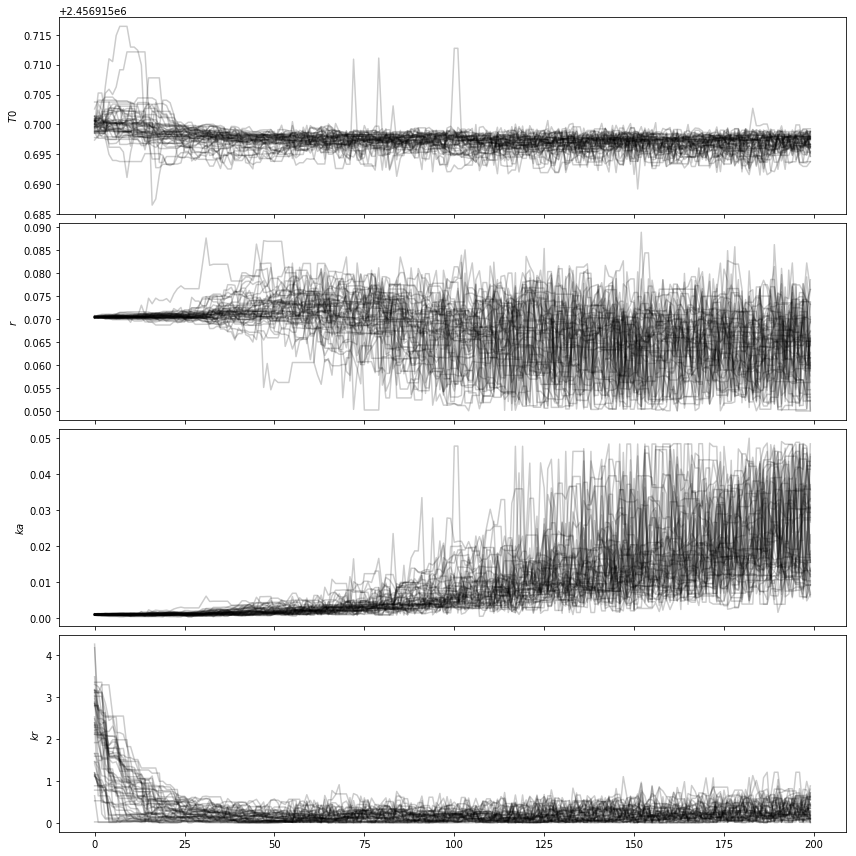

In [18]:
plt.figure('close')
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 12))
import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(4, 1)
gs1.update(wspace=0.025)

axes[0].plot(sampler.chain[0, :, :, 0].T, color="k", alpha=0.2)
#axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].set_ylabel("$T0$")

axes[1].plot(sampler.chain[0, :, :, 1].T, color="k", alpha=0.2)
#axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].set_ylabel("$r$")

#axes[2].plot(sampler.chain[:, :, 2].T, color="k", alpha=0.2)
#axes[2].yaxis.set_major_locator(MaxNLocator(5))
#axes[2].set_ylabel("$a$")

#axes[3].plot(sampler.chain[:, :, 3].T, color="k", alpha=0.2)
#axes[3].yaxis.set_major_locator(MaxNLocator(5))
#axes[3].set_ylabel("$b$")

#axes[4].plot(sampler.chain[:, :, 4].T, color="k", alpha=0.2)
#axes[4].yaxis.set_major_locator(MaxNLocator(5))
#axes[4].set_ylabel("$c$")

axes[2].plot(sampler.chain[0, :, :, 2].T, color="k", alpha=0.2)
#axes[5].yaxis.set_major_locator(MaxNLocator(5))
axes[2].set_ylabel("$k a$")

axes[3].plot(sampler.chain[0, :, :, 3].T, color="k", alpha=0.2)
#axes[6].yaxis.set_major_locator(MaxNLocator(5))
axes[3].set_ylabel("$k r$")

fig.tight_layout(h_pad=0.0)

In [19]:
sampler.reset()
print("Running second burn-in")
#print(p0.shape, lnp.shape)
#print(p0)
#p = p0[0][np.argmax(lnp[0])]
#p0 = plus_random_initial(p, nwalkers)
#p0 = p
#%time p0, _, _ = sampler.run_mcmc(p0, 1000)

p0, lnprob0, lnlike0 = p, lnprob, lnlike
sampler.reset()
print('\n ---------------------- CHAIN ---------------------- \n')
for p, lnprob, lnlike in sampler.sample(p0, lnprob0=lnprob0,
                                        lnlike0=lnlike0,
                                        iterations=1000):
    pass


Running second burn-in

 ---------------------- CHAIN ---------------------- 



<Figure size 432x288 with 0 Axes>

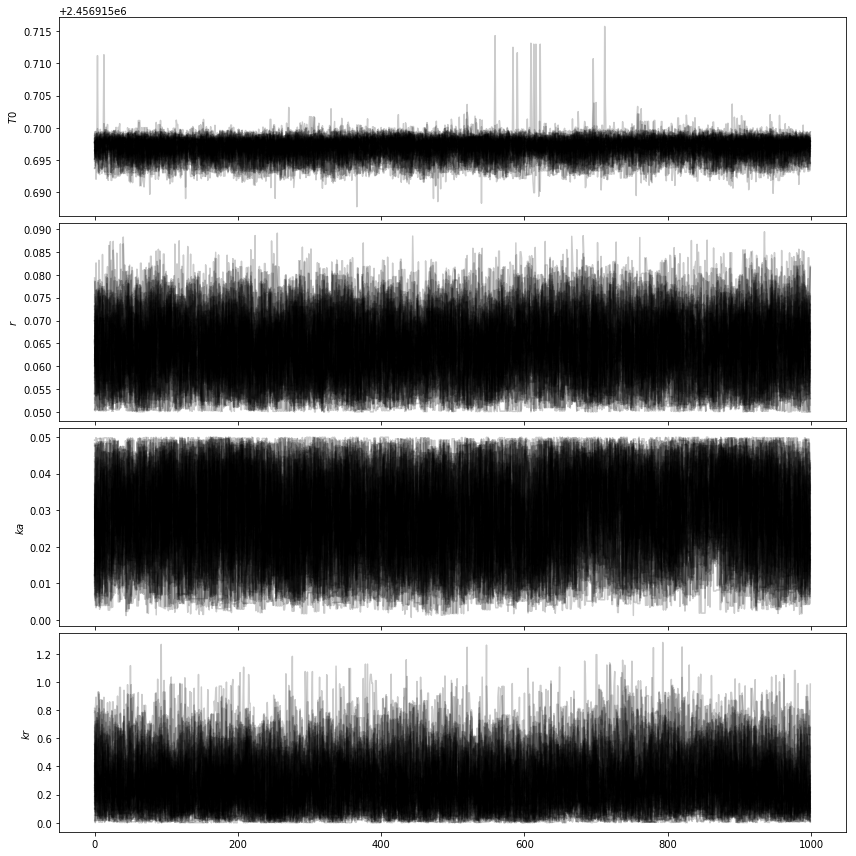

In [20]:
plt.figure('close')
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 12))
import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(4, 1)
gs1.update(wspace=0.025)

axes[0].plot(sampler.chain[0, :, :, 0].T, color="k", alpha=0.2)
#axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].set_ylabel("$T0$")

axes[1].plot(sampler.chain[0, :, :, 1].T, color="k", alpha=0.2)
#axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].set_ylabel("$r$")

#axes[2].plot(sampler.chain[:, :, 2].T, color="k", alpha=0.2)
#axes[2].yaxis.set_major_locator(MaxNLocator(5))
#axes[2].set_ylabel("$a$")

#axes[3].plot(sampler.chain[:, :, 3].T, color="k", alpha=0.2)
#axes[3].yaxis.set_major_locator(MaxNLocator(5))
#axes[3].set_ylabel("$b$")

#axes[4].plot(sampler.chain[:, :, 4].T, color="k", alpha=0.2)
#axes[4].yaxis.set_major_locator(MaxNLocator(5))
#axes[4].set_ylabel("$c$")

axes[2].plot(sampler.chain[0, :, :, 2].T, color="k", alpha=0.2)
#axes[5].yaxis.set_major_locator(MaxNLocator(5))
axes[2].set_ylabel("$k a$")

axes[3].plot(sampler.chain[0, :, :, 3].T, color="k", alpha=0.2)
#axes[6].yaxis.set_major_locator(MaxNLocator(5))
axes[3].set_ylabel("$k r$")

fig.tight_layout(h_pad=0.0)

In [21]:
samples = sampler.chain[0, :, -1000:, :].reshape((-1, ndim))

In [22]:
sampler.lnprobability

array([[[269.7558114 , 269.7558114 , 269.7558114 , ..., 269.16182885,
         268.66843122, 269.02456061],
        [269.28592132, 267.57672487, 268.69445844, ..., 269.87102932,
         269.87832904, 270.13329223],
        [269.90329015, 269.53073032, 268.50085907, ..., 269.01647751,
         269.01647751, 268.71685974],
        ...,
        [269.34616157, 268.34947856, 268.34947856, ..., 268.25671566,
         268.57353651, 268.95281586],
        [267.31892143, 269.4000278 , 269.4000278 , ..., 269.59749605,
         269.59749605, 269.72817461],
        [269.10345414, 268.19451655, 268.17101014, ..., 268.42139539,
         268.09954758, 269.43374122]],

       [[ 79.26976344,  79.14275881,  79.12019509, ...,  78.03976198,
          78.03976198,  78.03976198],
        [ 75.89544299,  76.53009104,  78.71292194, ...,  77.28570377,
          77.28570377,  76.47277952],
        [ 78.86324618,  78.4060989 ,  78.92142361, ...,  79.03837072,
          79.21717683,  79.38040394],
        ...,


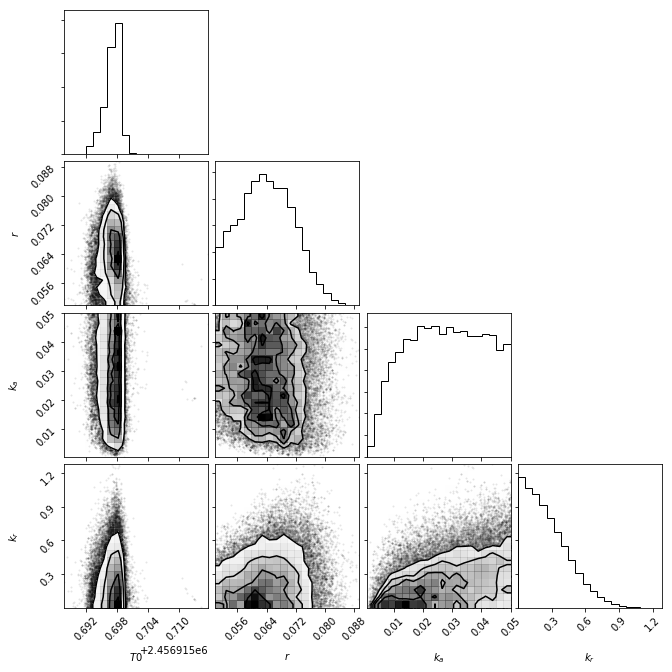

In [23]:
#fig = corner.corner(samples ,labels=["$T0$", "$r$", "$a$", "$b$", "$c$", "$k_a$", "$k_r$"])
fig = corner.corner(samples ,labels=["$T0$", "$r$", "$k_a$", "$k_r$"])

In [24]:
T0_f, r_f, ka_f, kr_f = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print('T0 = ' + str(T0_f))
print('r = ' + str(r_f))
print('k a = ' + str(ka_f))
print('k r = ' + str(kr_f))

T0 = (2456915.697355258, 0.0010478422045707703, 0.0018055629916489124)
r = (0.06377535753897773, 0.007796892949455764, 0.00786433202933419)
k a = (0.0278890718957462, 0.014619445296243011, 0.014502978882819123)
k r = (0.22656735905414685, 0.23992662025386238, 0.16059694335564756)


yo obtuve:
T0 = (2458053.6577679506, 0.0015464602038264275, 0.0010646553710103035)
r = (0.06447607896996906, 0.00920304179394403, 0.01381596102572475)
k a = (0.13651035610130569, 1.74154620296336, 1.1015554865475325)
k r = (0.5730572160268342, 1.4308390348642437, 1.1053297737353014)

T0 = (2456915.6972045074, 0.0010906718671321869, 0.0020262724719941616)

r = (0.06360921747112297, 0.007785649417432608, 0.007901026118737497)

k a = (0.025924599094419805, 0.015336339891361218, 0.013167380226103965)

k r = (0.21763415380978535, 0.2335909674248785, 0.15616969705408557

In [25]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

In [36]:
print(y)

[0.998927   1.00186496 1.00056592 1.00183741 0.99944457 1.00353358
 1.00031493 1.00073499 1.00226853 0.99906239 1.00048818 0.99323222
 0.99689358 0.99686022 0.99769715 0.99511955 0.99614449 0.99532715
 0.99540444 0.99357956 0.99177886 0.99518788 0.99469739 0.99421871
 0.99562265 0.99639788 0.99435735 0.99556463 0.99392108 0.99686852
 1.00153712 1.00300257 0.99559148 1.00115079 1.00181098 0.99972952
 1.00290776 1.00009838 0.99883786 0.99753064 1.00081372 1.00126375
 0.99984814 0.99994798 1.00153765 1.00283541 0.99963551 0.99860428
 1.00305489 1.00070436 1.00036849 1.00280386 1.00426377 1.00243885
 1.00255811 1.00391941 1.00459756 1.00700975 1.00207544 1.0049712
 1.00617252 1.00723731 1.00444507 1.00593708]


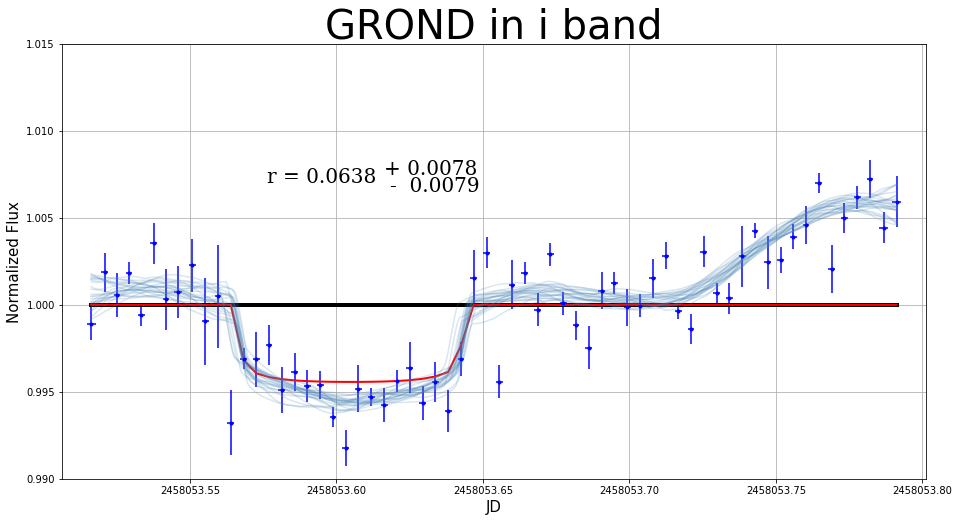

In [26]:
plt.subplots(figsize=(16,8))
plt.grid(True)
plt.xlim( (min(x)-0.01) , (max(x+0.01)))
plt.ylim(0.99, 1.015)

#std = np.std(y[-5:])

#plt.plot((x[0], x[-1]), (1.0 - std, 1.0 - std), 'k--', linewidth=2, alpha = 0.5)
#plt.plot((x[0], x[-1]), (1.0 + std , 1. + std), 'k--', linewidth=2, alpha = 0.5)
plt.plot((x[0], x[-1]), (1., 1.), 'k', linewidth=4)

plt.errorbar(x, y, yerr=y_error, fmt='b.', alpha=1/1.)

y_transit = Model([T0_f[0], r_f[0]], x)
plt.plot(x, y_transit, 'r',  linewidth=2)

#temp = x-x[0]
#y_model = y_transit + a_f[0] + b_f[0]*temp + c_f[0]*temp*temp
#plt.plot(x, y_model, 'g',  linewidth=2, alpha = 0.5)

plt.ylabel('Normalized Flux', fontsize=15)
plt.xlabel('JD', fontsize=15)
plt.title('GROND in i band', fontsize=40)
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.subplots_adjust(left=0.15)

#plt.text(x[0]+0.2, 1.005, r'STD = '+str(np.around(std, decimals=4)), fontdict=font)

r_t = str(np.around(r_f[0], decimals=4))
r_tp = str(np.around(r_f[1], decimals=4))
r_tm = str(np.around(r_f[2], decimals=4))
plt.text(x[0]+0.06, 1.007, 'r = '+ r_t , fontdict=font)
plt.text(x[0]+0.10, 1.0075, '+ '+ r_tp, fontdict=font)
plt.text(x[0]+0.102, 1.0065, '-  '+ r_tm, fontdict=font)

x2 = np.linspace(min(x), max(x), 1000)
if True:
    for s in samples[np.random.randint(len(samples), size=24)]:
        radius = 10.**s[-1]
        gp = george.GP(s[-2]* kernels.Matern32Kernel(radius))
        #gp = george.GP(0.2* kernels.Matern32Kernel(radius))
        gp.compute(x, y_error)
        m = gp.sample_conditional(y - Model(s[:-2], x), x2) + Model(s[:-2], x2)
        plt.plot(x2, m, '-', color="#4682b4", alpha=0.2)


In [38]:
print ( r'r = '+r_t+' + '+r_tp +' - '+r_tm)
print(T0_f[0], r_f[0], x)

r = 0.06378 + 0.0078 - 0.00786
2456915.697355258 0.06377535753897773 [2458053.51623389 2458053.52085127 2458053.52501813 2458053.52918464
 2458053.53337581 2458053.53756641 2458053.54175423 2458053.54594436
 2458053.55080546 2458053.55515723 2458053.55954397 2458053.56390756
 2458053.56825932 2458053.57262221 2458053.57697454 2458053.58133812
 2458053.58570112 2458053.59006483 2458053.59445086 2458053.59880448
 2458053.6031552  2458053.60750743 2458053.61189395 2458053.6162566
 2458053.62062052 2458053.62499486 2458053.62938171 2458053.63373453
 2458053.63814639 2458053.64249595 2458053.64683557 2458053.65122242
 2458053.65556215 2458053.65994887 2458053.66431291 2458053.66868714
 2458053.67305097 2458053.67740378 2458053.68177788 2458053.6861528
 2458053.69053942 2458053.6949029  2458053.6992659  2458053.70360666
 2458053.70795808 2458053.71232166 2458053.71671973 2458053.72105981
 2458053.7254     2458053.72975224 2458053.73410401 2458053.73848195
 2458053.74287724 2458053.74723039 2

<ErrorbarContainer object of 3 artists>

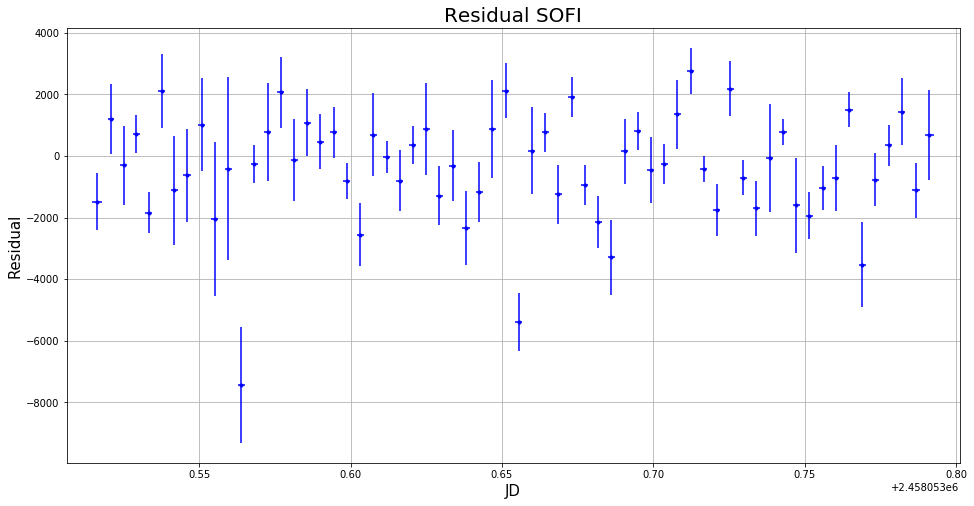

In [28]:
plt.subplots(figsize=(16,8))
plt.grid(True)
plt.xlim( (min(x)-0.01) , (max(x+0.01)))
plt.ylabel('Residual', fontsize=15)
plt.xlabel('JD', fontsize=15)
plt.title('Residual SOFI', fontsize=20)

# time
radius = 10.**kr_f[0]
kernel= ka_f[0] * kernels.Matern32Kernel(radius)

gp = george.GP(kernel)
gp.compute(x, y_error)

nsamples = y - Model((T0_f[0], r_f[0]), x)
gp_model = gp.sample_conditional(nsamples, x2)
m = gp_model + Model((T0_f[0], r_f[0]), x2)

m_f = np.interp(x, x2, m)


plt.errorbar(x, (y - m_f)*1000000, xerr=x_error, yerr=y_error*1000000, fmt='b.', alpha=1/1.)

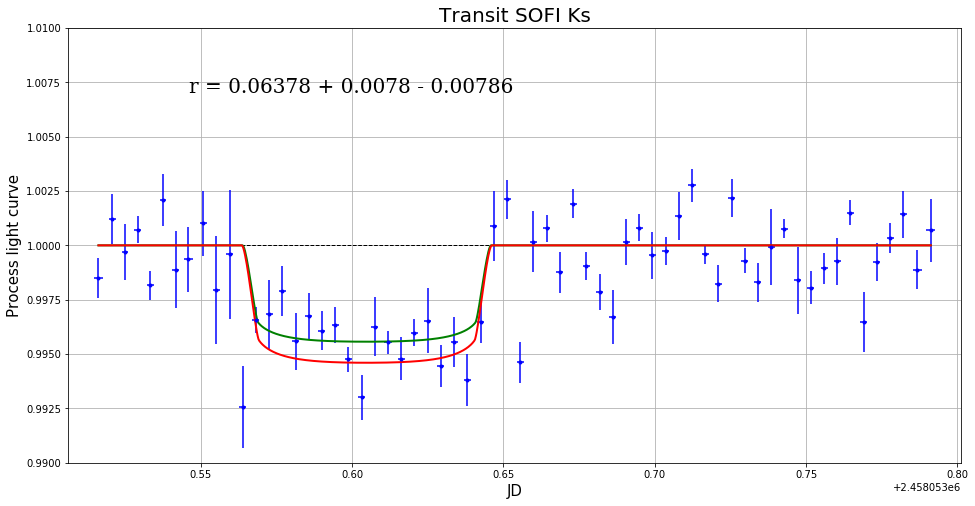

In [29]:
plt.subplots(figsize=(16,8))
plt.grid(True)
plt.xlim( (min(x)-0.01) , (max(x+0.01)))
plt.ylabel('Process light curve', fontsize=15)
plt.xlabel('JD', fontsize=15)
plt.title('Transit SOFI Ks', fontsize=20)
plt.ylim(0.99, 1.01)

r_t = str(np.around(r_f[0], decimals=5))
r_tp = str(np.around(r_f[1], decimals=5))
r_tm = str(np.around(r_f[2], decimals=5))
plt.plot((x[0], x[-1]), (1., 1.), 'k--', linewidth=1)
plt.text(x[0]+0.03, 1.007, r'r = '+r_t+' + '+r_tp +' - '+r_tm, fontdict=font)


m_f = np.interp(x, x2, m)
y_transit_f = transit_lightCurve(x2, T0_f[0], r_f[0], 101.1576001138329, 24.73712, 89.912)

plt.errorbar(x, (y - m_f + (y_transit)), xerr=x_error, yerr=y_error, fmt='b.', alpha=1/1.)
plt.plot(x2, y_transit_f, 'g',  linewidth=2)

y_transit_f = transit_lightCurve(x2, T0_f[0], 0.0704, 101.1576001138329, 24.73712, 89.912)
plt.plot(x2, y_transit_f, 'r',  linewidth=2)

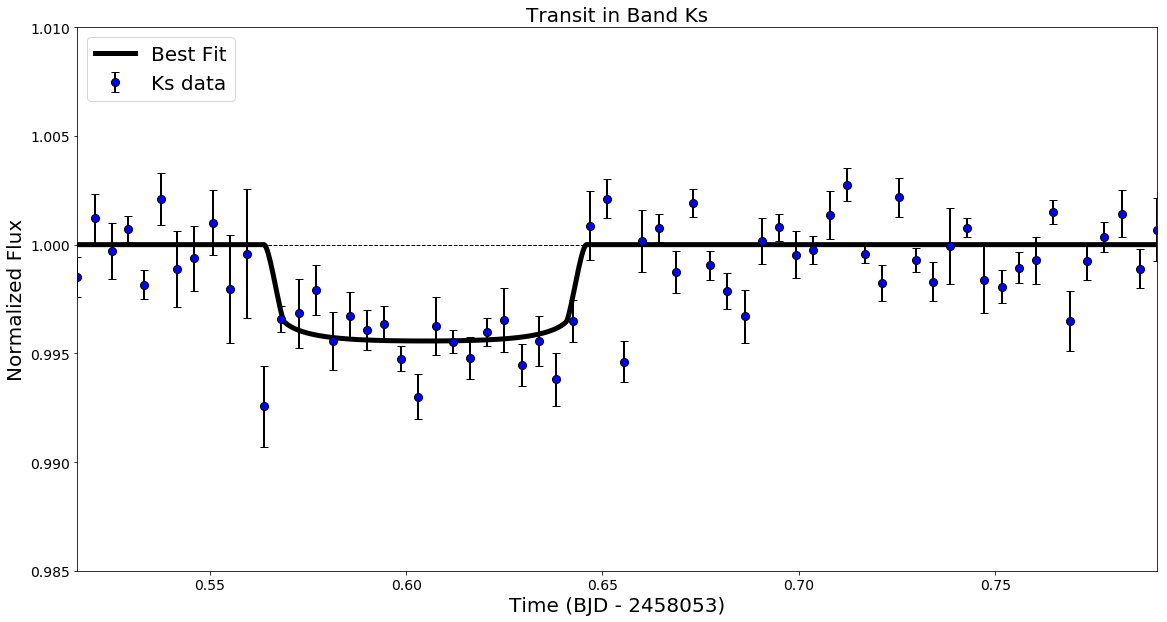

In [30]:
plt.subplots(figsize=(20,10))
plt.grid(False)
plt.xlim( (min(x)-0.01) , (max(x+0.01)))
plt.ylabel('Normalized Flux', fontsize=20)
plt.yticks(fontsize=14)
plt.xlabel('Time (BJD - 2458053)', fontsize=20)
plt.xticks(fontsize=14)
plt.title('Transit in Band Ks', fontsize=20)
plt.ylim(0.985, 1.010)
plt.xlim(x[0]-2458053, x[-1]-2458053)

r_t = str(np.around(r_f[0], decimals=5))
r_tp = str(np.around(r_f[1], decimals=5))
r_tm = str(np.around(r_f[2], decimals=5))
plt.plot((x[0]-2458053, x[-1]-2458053), (1., 1.), 'k--', linewidth=1)

m_f = np.interp(x, x2, m)
y_transit_f = transit_lightCurve(x2, T0_f[0], r_f[0], 101.1576001138329, 24.73712, 89.912)


plt.errorbar(x -2458053, (y - m_f + (y_transit)), yerr=y_error, fmt='k,', label='Ks data',
             marker='o', mfc='blue', mec='k', ms=8, mew=1, elinewidth= 2, capsize=4)

plt.plot(x2 -2458053, y_transit_f, 'k',  linewidth=5, label='Best Fit')


ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.subplots_adjust(left=0.15)
plt.legend(loc=2, fontsize=20)

In [31]:
'''
plt.subplots(figsize=(16,8))
plt.grid(False)
plt.xlim( (min(x)-0.01) , (max(x+0.01)))
plt.ylabel('Normalized Flux', fontsize=20)
plt.yticks(fontsize=14)
plt.xlabel('Time (BJD - 2458053)', fontsize=20)
plt.xticks(fontsize=14)
#plt.title('Transit in Band Ks', fontsize=20)
plt.ylim(0.985, 1.010)
plt.xlim(x[0]-58053, 58053.17-58053)

r_t = str(np.around(r_f[0], decimals=5))
r_tp = str(np.around(r_f[1], decimals=5))
r_tm = str(np.around(r_f[2], decimals=5))
plt.plot((x[0]-2458053, x[-1]-2458053), (1., 1.), 'k--', linewidth=1)

m_f = np.interp(x, x2, m)
y_transit_f = transit_lightCurve(x2, T0_f[0], r_f[0], 101.1576001138329, 24.73712, 89.912)


plt.errorbar(x -2458053, (y - m_f + (y_transit)), yerr=y_error, fmt='k,', label='Ks data',
             marker='o', mfc='blue', mec='k', ms=8, mew=1, elinewidth= 2, capsize=4)

plt.plot(x2 -2458053, y_transit_f, 'k',  linewidth=5, label='Best Fit')


m_f_2 = np.interp(jd, x2, m)
y_transit_f = transit_lightCurve(jd, T0_f[0], r_f[0], 101.1576001138329, 24.73712, 89.912)


plt.plot(jd -58053, (div - m_f_2 + (y_transit_f)), '.', alpha = 0.2)




ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.subplots_adjust(left=0.15)
plt.legend(loc=2, fontsize=20)
'''

"\nplt.subplots(figsize=(16,8))\nplt.grid(False)\nplt.xlim( (min(x)-0.01) , (max(x+0.01)))\nplt.ylabel('Normalized Flux', fontsize=20)\nplt.yticks(fontsize=14)\nplt.xlabel('Time (BJD - 2458053)', fontsize=20)\nplt.xticks(fontsize=14)\n#plt.title('Transit in Band Ks', fontsize=20)\nplt.ylim(0.985, 1.010)\nplt.xlim(x[0]-58053, 58053.17-58053)\n\nr_t = str(np.around(r_f[0], decimals=5))\nr_tp = str(np.around(r_f[1], decimals=5))\nr_tm = str(np.around(r_f[2], decimals=5))\nplt.plot((x[0]-2458053, x[-1]-2458053), (1., 1.), 'k--', linewidth=1)\n\nm_f = np.interp(x, x2, m)\ny_transit_f = transit_lightCurve(x2, T0_f[0], r_f[0], 101.1576001138329, 24.73712, 89.912)\n\n\nplt.errorbar(x -2458053, (y - m_f + (y_transit)), yerr=y_error, fmt='k,', label='Ks data',\n             marker='o', mfc='blue', mec='k', ms=8, mew=1, elinewidth= 2, capsize=4)\n\nplt.plot(x2 -2458053, y_transit_f, 'k',  linewidth=5, label='Best Fit')\n\n\nm_f_2 = np.interp(jd, x2, m)\ny_transit_f = transit_lightCurve(jd, T0_f[0

In [32]:
#np.save('GROND_r_finalPlotsdata', (x -2458053, (y - m_f + (y_transit)), y_error))

In [33]:
madness

0

In [34]:
xx

array([2458053.51623389, 2458053.52085127, 2458053.52501813,
       2458053.52918464, 2458053.53337581, 2458053.53756641,
       2458053.54175423, 2458053.54594436, 2458053.55080546,
       2458053.55515723, 2458053.55954397, 2458053.56390756,
       2458053.56825932, 2458053.57262221, 2458053.57697454,
       2458053.58133812, 2458053.58570112, 2458053.59006483,
       2458053.59445086, 2458053.59880448, 2458053.6031552 ,
       2458053.60750743, 2458053.61189395, 2458053.6162566 ,
       2458053.62062052, 2458053.62499486, 2458053.62938171,
       2458053.63373453, 2458053.63814639, 2458053.64249595,
       2458053.64683557, 2458053.65122242, 2458053.65556215,
       2458053.65994887, 2458053.66431291, 2458053.66868714,
       2458053.67305097, 2458053.67740378, 2458053.68177788,
       2458053.6861528 , 2458053.69053942, 2458053.6949029 ,
       2458053.6992659 , 2458053.70360666, 2458053.70795808,
       2458053.71232166, 2458053.71671973, 2458053.72105981,
       2458053.7254    ,